In [2]:
#tensorflow.debugging.set_log_device_placement(True)

# !pip install opencv-python

import cv2
import random
import GPyOpt as gy
import noise as ns
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import io
import os


mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


tf.config.list_physical_devices('GPU')
#tf.test.is_built_with_cuda()

2023-12-01 22:04:39.500155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


[]

In [3]:
main_path = os.path.dirname(os.path.abspath("Main.ipynb")) #path of main folder
data_path = os.path.join(main_path, "imagenet_val") #path of validation data

images = {}
classfiles = os.listdir(data_path)
print(classfiles)

for clf in classfiles:
    images[clf] = os.listdir(os.path.join(data_path,clf))


['n03125729', 'n02105855', 'n09193705', 'n04263257', 'n01751748']


In [4]:
images

{'n03125729': ['ILSVRC2012_val_00000005.JPEG'],
 'n02105855': ['ILSVRC2012_val_00000003.JPEG'],
 'n09193705': ['ILSVRC2012_val_00000002.JPEG'],
 'n04263257': ['ILSVRC2012_val_00000004.JPEG'],
 'n01751748': ['ILSVRC2012_val_00000001.JPEG']}

In [5]:
pretrained_model = tf.keras.applications.InceptionV3(
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.inception_v3.decode_predictions

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=6)[0]

imagesize = 299

2023-12-01 22:04:40.702064: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
class randomimg:
    
    def __init__(self):
        print("NEW INSTANCE")
        self.count = 0
        cls = random.choice(classfiles)
        # print(images[cls])
        imgfile = random.choice(images[cls])
        # imgfile = images[cls]
        imgpath = os.path.join(data_path, cls+"/"+imgfile)
        # imgpath = imgfile
        # print(cls)
        print(imgfile)
        print(imgpath)
            
        rawimage = Image.open(imgpath)
        image = tf.keras.preprocessing.image.img_to_array(rawimage)

        image = tf.cast(image, tf.float32)
        image = image/255
        image = tf.image.resize(image, (imagesize, imagesize))
        image = image[None, ...]
        
        self.imgplot = rawimage 
        
        if np.shape(image) == (1,imagesize,imagesize,1):
            image = tf.image.grayscale_to_rgb(image)
        elif np.shape(image) == (1,imagesize,imagesize,4):
            image = tf.image.grayscale_to_rgb(image)
            
        print(np.shape(image))
        self.img = image
        self.image_probs = get_imagenet_label(pretrained_model.predict(image, steps=1))
        self.labelindex = np.argmax(pretrained_model.predict(image, steps=1))
        origpredictions = self.image_probs[0]

        actualprediction = os.path.basename(os.path.dirname(imgpath))

        if self.image_probs[0][0] != actualprediction:
            self = randomimg()
        else:
            print(f"Imagenet prediction: {self.image_probs[0][0]}")
            print(f"Label: {actualprediction}")

    def decision(self,img):
        self.count += 1
        # print(f"Count: {self.count}")
        check = get_imagenet_label(pretrained_model.predict(img, steps=1))
        if check[0][0] != self.image_probs[0][0]:
            return True
        else:
            return False


In [7]:
def display_images(image):
    guessdata = get_imagenet_label(pretrained_model.predict(image, steps=1))
    for guess in guessdata:
        print(guess[1] + ": " + str(guess[2]))
        
    plt.figure()
    plt.imshow(image[0])
 # plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                 #  label, confidence*100))
    plt.show()

In [26]:
def norm (image, image2):
    y = image[0]
    z = image2[0]
    l2norm = tf.norm(np.subtract(z,y), ord=2).numpy()
    infnorm = tf.norm(np.subtract(z,y), ord=np.inf).numpy()
    return l2norm, infnorm

In [9]:
def select_delta(dist, l, cur_iter, theta, d):
    if cur_iter == 1:
        delta = 0.1
    else:
        if l == 'l2':
            delta=np.sqrt(d)*theta*dist
        elif l == 'linf':
            delta=np.sqrt(d)*theta*dist
    return delta

In [18]:
def clip_image(image, clip_min, clip_max):
	# Clip an image, or an image batch, with upper and lower threshold.
	return np.minimum(np.maximum(clip_min, image), clip_max)

NEW INSTANCE
ILSVRC2012_val_00000003.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n02105855/ILSVRC2012_val_00000003.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 166ms/step
NEW INSTANCE
ILSVRC2012_val_00000002.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n09193705/ILSVRC2012_val_00000002.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 150ms/step
NEW INSTANCE
ILSVRC2012_val_00000005.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n03125729/ILSVRC2012_val_00000005.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 157ms/step
NEW INSTANCE
ILSVRC2012_val_00000005.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n03125729/ILSVRC2012_val_00000005.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 126ms/step
NEW INSTANCE
ILSVRC2012_val_00000005.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n03125729/ILSVRC2012_val

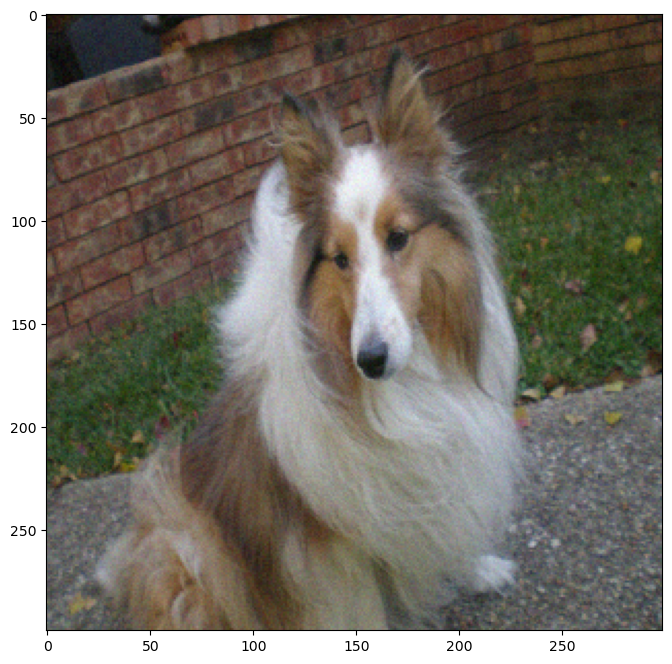

In [10]:
def random_noise_hsja(imgobj):
    tries = 0
    while tries < 1000:
        tries += 1
        noise = np.random.uniform(0,1,[1,imagesize,imagesize,3])
        if imgobj.decision(noise):
            break
    
    lo = 0.0
    hi = 1.0
    while hi - lo > 0.001:
        mid = (hi + lo) / 2.0
        blended = (1 - mid) * imgobj.img + mid * noise 
        if imgobj.decision(blended):
            hi = mid
        else:
            lo = mid
    
    final = (1 - hi) * imgobj.img + hi * noise
    return final

i = randomimg()
display_images(random_noise_hsja(i))

In [27]:
def project(original_image, perturbed_image, alphas, l):
    
    #alphas_shape = len(original_image.shape)
    #alphas = alphas.reshape(alphas_shape)
    if l == 'l2':
        return (1-alphas) * original_image + alphas * perturbed_image
    elif l == 'linf':
        out_images = clip_image(
            perturbed_image, 
            original_image - alphas, 
            original_image + alphas
        )
        return out_images
    
def binary_search_hsja(perturbed, imgobj, theta, l='l2'):
    
    distances = []
    for p in perturbed:
        if l == 'l2':
            distances.append(norm(p, imgobj.img)[0])
        else:
            distances.append(norm(p, imgobj.img)[1])    
    distances = np.array(distances)
    if l == 'linf':
        highs = distances
        thresholds = np.minimum(distances * theta, theta)
    else:
        highs = np.ones(len(perturbed))
        thresholds = theta

    lows = np.zeros(len(perturbed))
    
    while np.max((highs - lows) / thresholds) > 1:
        
        mids = (highs + lows) / 2.0
        
        decisions = np.array([])
        
        for p in range(len(perturbed)):
            mid_image = project(imgobj.img, perturbed[p], mids[p], l)
            d = imgobj.decision(mid_image)
            decisions = np.append(decisions, [d])
            
        # Update highs and lows based on model decisions.
        
        lows = np.where(decisions == 0, mids, lows)
        highs = np.where(decisions == 1, mids, highs)


    outputs = [project(imgobj.img, perturbed[p], highs[p], l) for p in range(len(perturbed))]
    
    finaldists = []
    for p in perturbed:
        if l == 'l2':
            finaldists.append(norm(p, imgobj.img)[0])
        else:
            finaldists.append(norm(p, imgobj.img)[1])
            
    idx = np.argmin(finaldists)

    dist = distances[idx]
    out_image = outputs[idx]
    return out_image, dist

        


#fin = binary_search_hsja([random_noise_hsja(im),random_noise_hsja(im)], im, theta, 'l2')

#print("Dist: "+str(fin[1]))

#delt  = select_delta(fin[1],constraint, 2, theta, d)

In [28]:
def approximate_gradient(sample, num_evals, delta, l):
    clip_max=1
    clip_min =1

    noise_shape = [num_evals] + list(sample.shape)
    if l == 'l2':
        rv = np.random.randn(*noise_shape)
    elif l == 'linf':
        rv = np.random.uniform(low = -1, high = 1, size = noise_shape)
    
    rv = rv / np.sqrt(np.sum(rv ** 2, axis = (1,2,3), keepdims = True))
    perturbed = sample + delta * rv
    #perturbed = clip_image(perturbed, clip_min, clip_max)
    rv = (perturbed - sample) / delta
    
    decisions = np.array([])
    for i in range(num_evals):
        check1 = get_imagenet_label(pretrained_model.predict(perturbed[i], steps=1))
        check2 = get_imagenet_label(pretrained_model.predict(sample, steps=1))
        boolean = [check1[0][0] != check2[0][0]]
        decisions = np.append(decisions, boolean)

    decision_shape = [len(decisions)] + [1] * len(sample.shape)
    fval = 2 * decisions.astype(float).reshape(decision_shape) - 1.0

    if np.mean(fval) == 1.0: # label changes. 
        gradf = np.mean(rv, axis = 0)
    elif np.mean(fval) == -1.0: # label not change.
        gradf = - np.mean(rv, axis = 0)
    else:
        fval -= np.mean(fval)
        gradf = np.mean(fval * rv, axis = 0) 

    # Get the gradient direction.
    gradf = gradf / np.linalg.norm(gradf)

    return gradf

#gradf = approximate_gradient(fin[0], 50, delt, constraint)
#display_images(i)

In [29]:
def geometric_progression(x, update, dist, cur_iter):

    epsilon = dist / np.sqrt(cur_iter) 

    def phi(epsilon):
        new = x + epsilon * update
        check1 = get_imagenet_label(pretrained_model.predict(new, steps=1))
        check2 = get_imagenet_label(pretrained_model.predict(x, steps=1))
        success = [check1[0][0] != check2[0][0]]
        return success

    while not phi(epsilon):
        epsilon /= 2.0

    return epsilon

#geometric_progression(fin[0], gradf, fin[1], 20)

In [30]:
def hsja(imgobj, #instance of class randomimg
            constraint = 'l2',
            num_iterations = 30,
            gamma = 1,
            max_num_evals = 1e4,
            init_num_evals = 100,
            verbose = True
            ):
    d = np.prod(imgobj.img.shape)
    
    if constraint == 'l2':
        theta = gamma / d**(3/2)
    else:
        theta = gamma / d**2
        
    perturbed = random_noise_hsja(imgobj)
    
    perturbed, dist_post = binary_search_hsja([perturbed], imgobj, theta, constraint)
    
    if constraint == 'l2': 
        
        dist = norm(perturbed, imgobj.img)[0]
        print(dist)
    else:
        dist = norm(perturbed, imgobj.img)[1]
    
    for j in np.arange(num_iterations):
        print('start')
        c_iter = j + 1

        # Choose delta.
        delta = select_delta(dist, constraint, c_iter, theta, d)
        print("Delta" + str(delta))
        # Choose number of evaluations.
        num_evals = int(init_num_evals * np.sqrt(c_iter))
        num_evals = int(min([num_evals, max_num_evals]))
        
        # approximate gradient.
        gradf = approximate_gradient(perturbed, num_evals, 
            delta, constraint)
        
        if constraint == 'linf':
            update = np.sign(gradf)
        else:
            update = gradf
        # find step size.
        epsilon = geometric_progression(perturbed, 
        update, dist, c_iter)
        print(epsilon)
        # Update the sample. 
        perturbed =  perturbed + epsilon * update

        # Binary search to return to the boundary. 
        perturbed, dist_post = binary_search_hsja(perturbed, imgobj, theta, constraint)
        
        # compute new distance.
        if constraint == 'l2': 
            dist = norm(perturbed, imgobj.img)[0]
        else:
            dist = norm(perturbed, imgobj.img)[1]
            
        if verbose:
            print('iteration: {:d}, {:s} distance {:.4E}'.format(j+1, constraint, dist))

    return perturbed

i = randomimg()
hsja = hsja(i, constraint = 'linf')
display_images(hsja)

NEW INSTANCE
ILSVRC2012_val_00000005.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n03125729/ILSVRC2012_val_00000005.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 154ms/step
NEW INSTANCE
ILSVRC2012_val_00000004.JPEG
/home/ehs28/Adversarial-Black-Box-Attacker/HSJattack/imagenet_val/n04263257/ILSVRC2012_val_00000004.JPEG
(1, 299, 299, 3)
1/1 [==============================] - 0s 118ms/step
Imagenet prediction: n04263257
Label: n04263257
1/1 [==============================] - 0s 169ms/step
start
Delta0.1
1/1 [==============================] - 0s 153ms/step
0.32634636759757996
1/1 [==============================] - 0s 189ms/step
iteration: 1, linf distance 1.5779E-01
start
Delta1.1360466966935883e-09
1/1 [==============================] - 0s 146ms/step
0.11157750155216382
1/1 [==============================] - 0s 249ms/step
iteration: 2, linf distance 2.6937E-01
start
Delta1.9393530196702016e-09
1/1 [==============================] - 0s 149ms/step

In [6]:
def perlin_noise(noise_scale, noise_octaves,  color_freq, noise_p=1, noise_l=2):
    blank = np.zeros((imagesize,imagesize, 3))
    for i in range(imagesize):
        for j in range(imagesize):
            for k in range(3):
                blank[i][j][k] = .5+ns.pnoise2(i/int(noise_scale), 
                                      j/int(noise_scale), 
                                      octaves=int(noise_octaves), 
                                      persistence=float(noise_p), 
                                      lacunarity=float(noise_l), 
                                      repeatx=imagesize, 
                                      repeaty=imagesize, 
                                      base = 0
                                      )
    blank = np.sin(blank*color_freq*np.pi)
      
    return blank

In [7]:
def gabor_noise_random(number_kernel, kernel_size, sigma, orientation, scale):
    grid = 20
    imgsize = imagesize
    rang = int(imgsize/2//grid)
    gabor_kern = cv2.getGaborKernel((int(kernel_size), int(kernel_size)), float(sigma), float(orientation), float(scale), 1, 0, ktype = cv2.CV_32F)
    blank = np.zeros((imagesize,imagesize,3))
    for i in range (-rang, rang):
        for j in range(-rang, rang):
            x = grid*i + (imgsize/2) 
            y = grid*j+ (imgsize/2) 
            for k in range(int(number_kernel)):
                dx = np.random.randint(0, grid)
                dy = np.random.randint(0, grid)
                while x + dx >= imgsize or x +dx < 0 or y + dy >= imgsize or y +dy < 0:
                    dx = np.random.randint(0, grid)
                    dy = np.random.randint(0, grid)
                w = np.random.random()*2 - 1
                for l in range(3): blank[int(x+dx)][int(y)+dy][l] = w
            blank = cv2.filter2D(blank, -1, gabor_kern)
    blank = tf.clip_by_value(blank.astype('float32'), 0, 1)
    return blank


(1, 299, 299, 3)
vestment: 0.9881738
altar: 0.006325635
barometer: 0.0002679812
tray: 0.00024090963
crutch: 0.00023163966
chime: 0.00022480401


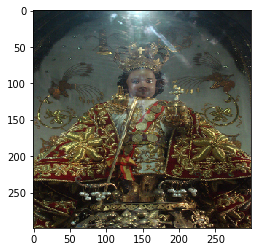

vestment: 0.9861827
altar: 0.009353843
mask: 0.00038997957
throne: 0.00024182649
spiny_lobster: 0.000109685774
bib: 9.3102244e-05


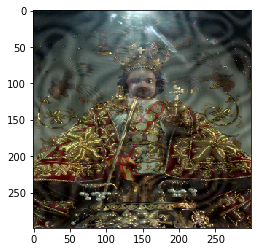

In [8]:
def create_distorted_image(image, typ, epsilon, parameters):
    parameters = parameters[0]
    if typ == 'perlin':
        pert = perlin_noise(parameters[0], parameters[1], parameters[2])
    elif typ == 'gabor':
        pert = gabor_noise_random(parameters[0], parameters[1], parameters[2], parameters[3], parameters[4])
   
    dist_img = image + epsilon*pert
    dist_img = tf.clip_by_value(dist_img, 0, 1)
    return dist_img

image = randomimg()
display_images(image.img)
n = create_distorted_image(image.img, "perlin", 16.0/255, [[100,2, 10]])
display_images(n)

In [10]:
class preddifference:
    def __init__(self, image, maxnorm):
        self.image = image
        self.maxnorm = maxnorm
        pass
    def func(self, parameters):
        final = create_distorted_image(self.image.img, noise, self.maxnorm/255, parameters)
        rawpredict = pretrained_model.predict(final)
        #print("Query")
        predictions = get_imagenet_label(rawpredict)
        origprob = rawpredict[0][self.image.labelindex]
        return origprob-predictions[1][2]

In [13]:
def bayesian_attack(max_query, init_query, noise, max_norm):
    if noise == 'perlin':
        bounds = [{'name' : 'wavelength', 'type' : 'continuous', 'domain' : (200, 10), 'dimensionality' : 1},
                {'name' : 'octave'  , 'type' : 'discrete'  , 'domain' : (1,2,3,4), 'dimensionality' : 1},
               # {'name' : 'persistence'  , 'type' : 'continuous'  , 'domain' : (0, 2), 'dimensionality' : 1},
               # {'name' : 'lac'  , 'type' : 'continuous'  , 'domain' : (0, 4), 'dimensionality' : 1},
                {'name' : 'freq_sine', 'type' : 'continuous', 'domain' : (4, 32), 'dimensionality' : 1},
                ]
    elif noise == 'gabor':
        bounds = [{'name' : 'kernels', 'type' : 'discrete', 'domain' : (30, 3), 'dimensionality' : 1},
                {'name' : 'kernel size'  , 'type' : 'discrete'  , 'domain' : (1,10), 'dimensionality' : 1},
                {'name' : 'sigma'  , 'type' : 'continuous'  , 'domain' : (2, 7), 'dimensionality' : 1},
                {'name' : 'orientation'  , 'type' : 'continuous'  , 'domain' : (0, np.pi), 'dimensionality' : 1},
                {'name' : 'scale', 'type' : 'continuous', 'domain' : (2, 10), 'dimensionality' : 1},
                ]

    image = randomimg()
    
    feasible_space = gy.Design_space(space = bounds)        
    initial_design = gy.experiment_design.initial_design('random', feasible_space, init_query)

    best_f = 1
    queries = 0

    optimized = preddifference(image, max_norm)

    # Gaussian process and Bayesian optimization
    objective = gy.core.task.SingleObjective(optimized.func, num_cores = 1)
    model = gy.models.GPModel(exact_feval = False, optimize_restarts = 5, verbose = False)
    aquisition_opt = gy.optimization.AcquisitionOptimizer(feasible_space)
    acquisition = gy.acquisitions.AcquisitionLCB(model, feasible_space, optimizer = aquisition_opt)
    evaluator = gy.core.evaluators.Sequential(acquisition, batch_size = 1)

    #im = create_distorted_image(image, 'perlin', .05, [100, 3, 1, 2, 20])
    #display_images(im)
    BOpt = gy.methods.ModularBayesianOptimization(model, feasible_space, objective, acquisition, evaluator, initial_design)

    while queries < max_query and best_f > 0:
        queries += 1
        BOpt.run_optimization(max_iter = 1)
        best_f = BOpt.fx_opt
        if queries % 5 == 0: print('Query %i, Objective Function %0.2f' % (queries, best_f)) # Print every 5th query

    if best_f > 0:
        success = 0.0
        print('Attack failed.')
    else:
        success = 1.0
        print('Success! ' + str(queries) + " Queries!")

    # Evaluate best parameters
    fparams = [BOpt.x_opt]

   
    final = create_distorted_image(image.img, noise, max_norm/255, fparams)
    twonorm, infnorm = norm(image.img,final)
    return success, queries,  twonorm, infnorm, final



(1, 299, 299, 3)
Success! 1 Queries!
Image0
spaghetti_squash: 0.3268956
croquet_ball: 0.14056133
acorn_squash: 0.059536938
maraca: 0.043734413
butternut_squash: 0.03877846
orange: 0.011073212


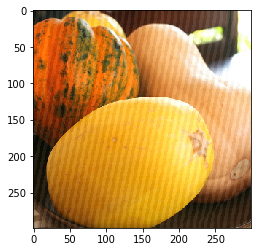

(1, 299, 299, 3)
(1, 299, 299, 3)
Success! 1 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.90
Query 10, Objective Function 0.85
Query 15, Objective Function 0.85
Query 20, Objective Function 0.81
Query 25, Objective Function 0.80
Query 30, Objective Function 0.76
Query 35, Objective Function 0.76
Query 40, Objective Function 0.76
Query 45, Objective Function 0.76
Query 50, Objective Function 0.67
Query 55, Objective Function 0.67
Query 60, Objective Function 0.67
Query 65, Objective Function 0.67
Query 70, Objective Function 0.67
Query 75, Objective Function 0.67
Query 80, Objective Function 0.67
Query 85, Objective Function 0.67
Query 90, Objective Function 0.67
Query 95, Objective Function 0.67
Query 100, Objective Function 0.67
Attack failed.
(1, 299, 299, 3)
Success! 1 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.89
Query 10, Objective Function 0.89
Query 15, Objective Function 0.89
Query 20, Objective Function 0.89
Query 25, Objective Function 0.89
Query 30, O

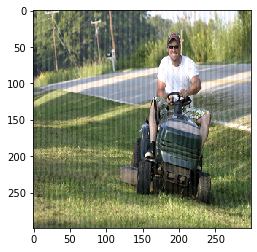

(1, 299, 299, 3)
Query 5, Objective Function 0.94
Query 10, Objective Function 0.90
Query 15, Objective Function 0.90
Query 20, Objective Function 0.90
Query 25, Objective Function 0.90
Query 30, Objective Function 0.90
Query 35, Objective Function 0.90
Query 40, Objective Function 0.90
Query 45, Objective Function 0.90
Query 50, Objective Function 0.90
Query 55, Objective Function 0.90
Query 60, Objective Function 0.90
Query 65, Objective Function 0.90
Query 70, Objective Function 0.90
Query 75, Objective Function 0.90
Query 80, Objective Function 0.90
Query 85, Objective Function 0.90
Query 90, Objective Function 0.90
Query 95, Objective Function 0.90
Query 100, Objective Function 0.90
Attack failed.
(1, 299, 299, 3)
(1, 299, 299, 3)
Success! 2 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.92
Query 10, Objective Function 0.90
Query 15, Objective Function 0.90
Query 20, Objective Function 0.90
Query 25, Objective Function 0.90
Query 30, Objective Function 0.90
Query 35, Obje

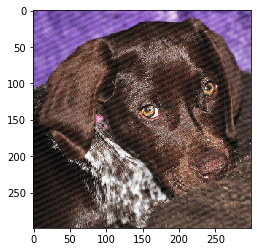

(1, 299, 299, 3)
(1, 299, 299, 3)
Success! 4 Queries!
(1, 299, 299, 3)
(1, 299, 299, 3)
Success! 1 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.78
Query 10, Objective Function 0.78
Query 15, Objective Function 0.78
Query 20, Objective Function 0.78
Query 25, Objective Function 0.78
Query 30, Objective Function 0.78
Query 35, Objective Function 0.78
Query 40, Objective Function 0.78
Query 45, Objective Function 0.78
Query 50, Objective Function 0.78
Query 55, Objective Function 0.78
Query 60, Objective Function 0.78
Query 65, Objective Function 0.78
Query 70, Objective Function 0.78
Query 75, Objective Function 0.78
Query 80, Objective Function 0.78
Query 85, Objective Function 0.78
Query 90, Objective Function 0.78
Query 95, Objective Function 0.78
Query 100, Objective Function 0.78
Attack failed.
(1, 299, 299, 3)
Query 5, Objective Function 0.30
Query 10, Objective Function 0.30
Query 15, Objective Function 0.30
Query 20, Objective Function 0.30
Query 25, Objective Function

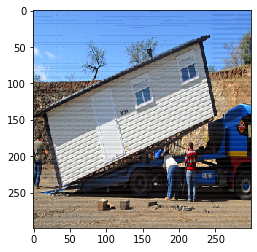

(1, 299, 299, 3)
Success! 2 Queries!
(1, 299, 299, 3)
(1, 299, 299, 3)
Success! 1 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.62
Query 10, Objective Function 0.62
Query 15, Objective Function 0.62
Query 20, Objective Function 0.62
Query 25, Objective Function 0.62
Query 30, Objective Function 0.62
Query 35, Objective Function 0.62
Query 40, Objective Function 0.62
Query 45, Objective Function 0.62
Query 50, Objective Function 0.62
Query 55, Objective Function 0.62
Query 60, Objective Function 0.62
Query 65, Objective Function 0.62
Query 70, Objective Function 0.62
Query 75, Objective Function 0.62
Query 80, Objective Function 0.60
Query 85, Objective Function 0.60
Query 90, Objective Function 0.60
Query 95, Objective Function 0.60
Query 100, Objective Function 0.60
Attack failed.
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
Query 5, Objective Function 0.06
Query 10, Objective Function 0.06
Query 15, Objective Function 0.06
Query 20, Objective Function 0.06
Query 25, O

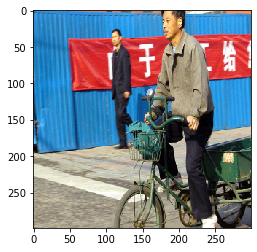

(1, 299, 299, 3)
Query 5, Objective Function 0.63
Query 10, Objective Function 0.39
Query 15, Objective Function 0.25
Query 20, Objective Function 0.19
Query 25, Objective Function 0.19
Query 30, Objective Function 0.14
Query 35, Objective Function 0.14
Query 40, Objective Function 0.14
Query 45, Objective Function 0.14
Query 50, Objective Function 0.14
Query 55, Objective Function 0.14
Query 60, Objective Function 0.14
Query 65, Objective Function 0.14
Query 70, Objective Function 0.14
Query 75, Objective Function 0.14
Query 80, Objective Function 0.14
Query 85, Objective Function 0.14
Query 90, Objective Function 0.14
Query 95, Objective Function 0.14
Query 100, Objective Function 0.14
Attack failed.
(1, 299, 299, 3)
(1, 299, 299, 3)
Query 5, Objective Function 0.97
Query 10, Objective Function 0.97
Query 15, Objective Function 0.97
Query 20, Objective Function 0.97
Query 25, Objective Function 0.97
Query 30, Objective Function 0.96
Query 35, Objective Function 0.96
Query 40, Objecti

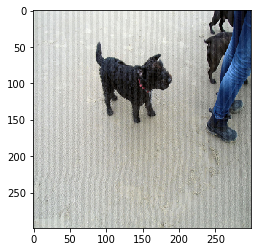

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
Success! 3 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.23
Query 10, Objective Function 0.15
Query 15, Objective Function 0.08
Query 20, Objective Function 0.08
Query 25, Objective Function 0.08
Query 30, Objective Function 0.03
Query 35, Objective Function 0.03
Query 40, Objective Function 0.00
Success! 40 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.42
Query 10, Objective Function 0.42
Query 15, Objective Function 0.41
Query 20, Objective Function 0.41
Query 25, Objective Function 0.41
Query 30, Objective Function 0.41
Query 35, Objective Function 0.41
Query 40, Objective Function 0.26
Query 45, Objective Function 0.26
Query 50, Objective Function 0.26
Query 55, Objective Function 0.26
Query 60, Objective Function 0.26
Query 65, Objective Function 0.26
Query 70, Objective Function 0.26
Query 75, Objective Function 0.21
Query 80, Objective Function 0.21
Query 85, Objective Function 0.21
Query 90,

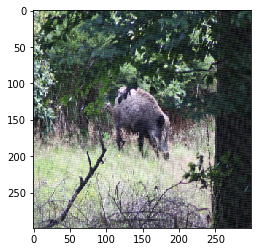

(1, 299, 299, 3)
Query 5, Objective Function 0.17
Query 10, Objective Function 0.13
Query 15, Objective Function 0.06
Query 20, Objective Function 0.06
Query 25, Objective Function 0.03
Query 30, Objective Function 0.00
Query 35, Objective Function 0.00
Query 40, Objective Function 0.00
Query 45, Objective Function 0.00
Query 50, Objective Function 0.00
Query 55, Objective Function 0.00
Query 60, Objective Function 0.00
Query 65, Objective Function 0.00
Query 70, Objective Function 0.00
Query 75, Objective Function 0.00
Query 80, Objective Function 0.00
Query 85, Objective Function 0.00
Query 90, Objective Function 0.00
Query 95, Objective Function 0.00
Query 100, Objective Function 0.00
Attack failed.
(1, 299, 299, 3)
Success! 1 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.81
Success! 9 Queries!
(1, 299, 299, 3)
Success! 4 Queries!
(1, 299, 299, 3)
Query 5, Objective Function 0.50
Query 10, Objective Function 0.31
Query 15, Objective Function 0.31
Query 20, Objective Functi

In [ ]:
maxquery = 100
initquery = 5
np.random.seed(0)
noise = 'gabor'
max_norm=16.0

test_size = 100
successes = 0
totalquery = 0
avg2norm = 0
avginfnorm = 0
k=0
for k in range(test_size-1):
    with tf.device('/GPU:0'): 
        temp1,temp2,temp3,temp4,returnimg = bayesian_attack(maxquery,initquery,noise, max_norm)
    successes+=temp1
    if temp1 != 0:
        totalquery+=temp2
        +-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    avg2norm+=(temp3/test_size)
    avginfnorm+=(temp4/test_size)
    
    if k % 10 == 0: 
        print("Image"+str(k))
        display_images(returnimg)

avgquery =(totalquery/successes)
successrate = successes/test_size

print("Success Rate: "+str(successrate))----------------------------------------
print("Average queries: "+str(avgquery))-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("Average 2 Norm: "+str(avg2norm))--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("Average Infinity Norm: "+str(avginfnorm))

In [ ]:
print("Success Rate: "+str(successrate))
print("Average queries: "+str(avgquery))
print("Average 2 Norm: "+str(avg2norm))
print("Average Infinity Norm: "+str(avginfnorm))

In [ ]:
print(avginfnorm)